In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np
factorial = np.math.factorial
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# Convert matplotlib figures into TikZ/PGFPlots
import tikzplotlib

# custom module where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_isoprob_transform # isoprobabilistic transform

# custom module
import Surrogates.PolynomialChaosExpansion as PCE

# Gauß-Legendre Quadrature 

Exactly integrates polynomial of degree: 2*number_of_quadrature_points-1

numpy package has been tested upto 100 points

In [3]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights

    return quad_points, quad_weights

# Generalised Sobol Indices using Pick and Freeze Estimator

In [4]:
def generalised_sobol_indices(model, A, B, N, t_max, N_quad):

    '''
    Inputs:

    model = function that returns model output for given input
    t = t_i = time to at which model must be evaluated
    A = First set of inputs of size [N,N_p]
    B = Second set of inputs of size [N,N_p] 
    Q = number of temporal quadrature points

    Outputs:

    G_U = Generalised First order Sobol Indices of size [N_p,Q]
    G_total_U = Generalised Total Sobol Indices of size [N_p,Q]

    '''
    N_p = 3

    quad_points, quad_weights = GaussLegendreQuadrature(0, t_max, N_quad)

    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    T = np.tile(quad_points, (N, 1)) # repeat row 't' along axis 0

    f_A = model(A, T).T # [n_t, N] vector with evaluations at x_A
    f_B = model(B, T).T # [n_t, N] vector with evaluations at x_B

    # store f_C
    f_C = np.zeros((f_A.shape[0], f_A.shape[1], N_p)) # [n_t, N, N_p] 3d array with evaluations at x_C_i

    for i in range(N_p):
        f_C[:, :, i] = model(get_C_i(i), T).T # [n_t, N] vector with evaluations at x_C_i

    G_U = np.zeros((N_p)) # store first order sensitivity for each parmeter for each point in time
    G_total_U = np.zeros((N_p)) # store total sensitivity for each parmeter for each point in time

    for i in range(N_p):

        D_t = 0 # denominator
        D_U = 0 # numerator first order indices
        D_U_c = 0 # numerator total order indices

        for k, t_m in enumerate(quad_points):
            
            f_A_t = f_A[k, :]
            f_B_t = f_B[k, :]
            f_C_t_i = f_C[k, :, i]

            f_mean_t = np.mean(f_A_t)

            D_t += ( (np.dot(f_A_t,f_A_t)/N) - f_mean_t**2 ) * quad_weights[k]

            D_U += ( (np.dot(f_A_t,f_C_t_i)/N - f_mean_t**2) ) * quad_weights[k]

            D_U_c += ( (np.dot(f_B_t,f_C_t_i)/N - f_mean_t**2) ) * quad_weights[k]

        G_U[i] = D_U/D_t
        G_total_U[i] = 1 - D_U_c/D_t

    return G_U, G_total_U

# Compute Indices

In [5]:
N = int(1e5/2)
X = mech_oscillator_samples(2*N)
A = X[:N, :]
B = X[N:, :]

N_quad = 25
N_p = 3
n_t = 51

t_linspace = np.linspace(0.1, 10, n_t)

G_U_evolution_MC = np.zeros((N_p, n_t))
G_total_U_evolution_MC = np.zeros((N_p, n_t))

for j, t in enumerate(tqdm(t_linspace, desc = 'Computing Indices', ncols=100)):

    G_U, G_total_U = generalised_sobol_indices(mech_oscillator, A, B, N, t, N_quad)

    G_U_evolution_MC[:, j] =  G_U
    G_total_U_evolution_MC[:, j] = G_total_U

Computing Indices: 100%|████████████████████████████████████████████| 51/51 [00:23<00:00,  2.15it/s]


# First Order Indices

Text(0, 0.5, 'Generalised First-order Sobol indices')

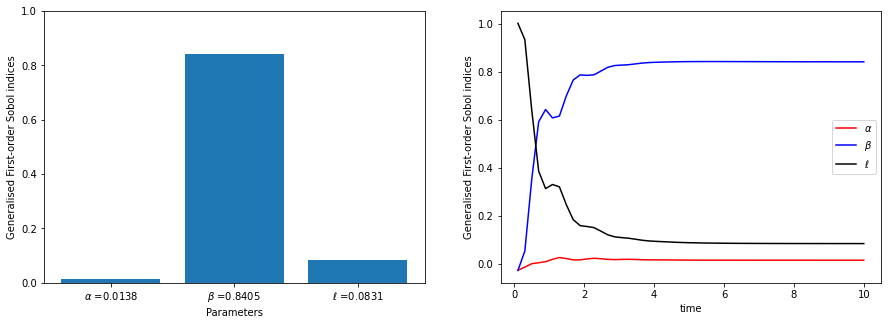

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

'Histogram of general total Sobol indices at t=T'
params = [r'$\alpha$ =' + str(np.around(G_U_evolution_MC[0,-1], 4)), 
          r'$\beta$ =' +  str(np.around(G_U_evolution_MC[1,-1], 4)), 
          r'$\ell$ =' +     str(np.around(G_U_evolution_MC[2,-1], 4))]

ax[0].bar(params,G_U_evolution_MC[:,-1])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Parameters')
ax[0].set_ylabel('Generalised First-order Sobol indices')

'Evolution of general total Sobol indices'
ax[1].plot(t_linspace,G_U_evolution_MC[0,:], color = 'red',   label = r'$\alpha$')
ax[1].plot(t_linspace,G_U_evolution_MC[1,:], color = 'blue',  label = r'$\beta$')
ax[1].plot(t_linspace,G_U_evolution_MC[2,:], color = 'black', label = r'$\ell$')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Generalised First-order Sobol indices')

# Total Order Indices

Text(0, 0.5, 'Generalised Total-order Sobol indices')

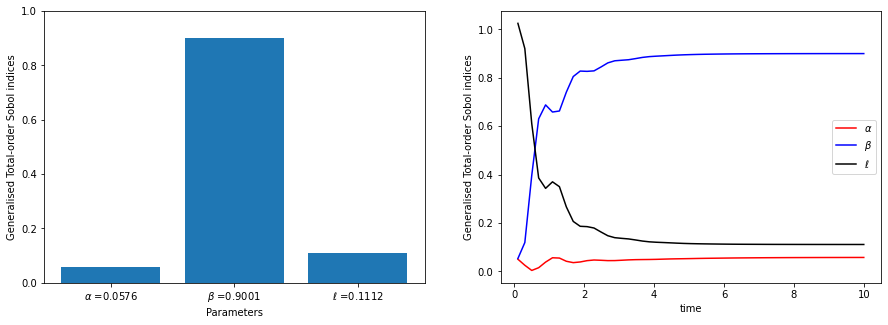

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

'Histogram of general total Sobol indices at t=T'
params = [r'$\alpha$ =' + str(np.around(G_total_U_evolution_MC[0,-1], 4)), 
          r'$\beta$ =' +  str(np.around(G_total_U_evolution_MC[1,-1], 4)), 
          r'$\ell$ =' +     str(np.around(G_total_U_evolution_MC[2,-1], 4))]

ax[0].bar(params,G_total_U_evolution_MC[:,-1])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Parameters')
ax[0].set_ylabel('Generalised Total-order Sobol indices')

'Evolution of general total Sobol indices'
ax[1].plot(t_linspace, G_total_U_evolution_MC[0,:], color = 'red',   label = r'$\alpha$')
ax[1].plot(t_linspace, G_total_U_evolution_MC[1,:], color = 'blue',  label = r'$\beta$')
ax[1].plot(t_linspace, G_total_U_evolution_MC[2,:], color = 'black', label = r'$\ell$')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Generalised Total-order Sobol indices')

# Generalised Sobol Indices using PCE Surrogate

In [10]:
class GSI_PCE(PCE.PCE_surrogate):

    def __init__(self, number_training_points, total_polynomial_degree, polynomial_classes_of_random_variables, 
                 model, sample_generator, isoprob_transform):

        self.training_points = number_training_points
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables
        self.N_p = len(self.pcrv)
        self.model = model
        self.sample_generator = sample_generator
        self.isoprob_transform = isoprob_transform

        # set classes of random variables
        for i in range(self.N_p):

            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre

        #total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))

        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)

    def generalised_Sobol(self, t_min, t_max, PCE_error):

        first_order_picker, total_order_picker = self.coefficient_pickers()

        # Numerical integration in time: T = [0, t_max]
        number_quad_points = 20
        self.T, quad_weights = GaussLegendreQuadrature(t_min, t_max, number_quad_points)

        # store generalised first order Sobol index
        self.G_U_store = np.zeros((self.N_p))

        # store generalised total order Sobol index
        self.G_U_t_store = np.zeros((self.N_p))

        # generalised first order Sobol index
        G_U_numerator = 0

        # generalised total order Sobol index
        # denominator is same in both cases
        G_U_t_numerator = 0
        G_U_t_denominator = 0

        # store error at each quad_point
        self.store_PCE_error = np.zeros(number_quad_points)

        # pick random samples for computing coefficients
        X_train = self.sample_generator(self.training_points)

        for i, t in enumerate(self.T):

            # evaluate model 
            Y = self.model(X_train, t)

            # find PCE coefficients
            y = self.find_coefficients(X_train, Y)

            if PCE_error:

                # error_estimate
                self.store_PCE_error[i] = self.LeaveOneOut(X_train, Y)

            G_U_numerator += first_order_picker @ (y**2) * quad_weights[i]

            G_U_t_numerator += total_order_picker @ (y**2) * quad_weights[i]

            G_U_t_denominator += np.sum(y[1:]**2) * quad_weights[i]

            G_U = G_U_numerator/G_U_t_denominator

            G_U_t = G_U_t_numerator/G_U_t_denominator

        self.G_U_store = G_U.flatten()
        self.G_U_t_store = G_U_t.flatten()

        return self.G_U_store, self.G_U_t_store

    def plot_PCE_error(self):

        # resolution of plot goverened by number of quadrature points in self.T
        fig, ax = plt.subplots(figsize=(6,5)) 

        ax.plot(self.T, self.store_PCE_error, color = 'red')
        ax.set_xlabel('time')
        ax.set_ylabel('PCE Error')
        ax.set_title('Leave One Out PCE Error')

        plt.show()


In [11]:
number_training_points = 10_000
n = 5
polynomial_classes_of_random_variables = ['Legendre', 'Legendre', 'Legendre']
model = mech_oscillator
sample_generator = mech_oscillator_samples

mech_oscillator_PCE = GSI_PCE(number_training_points, n, polynomial_classes_of_random_variables, 
                                    model, sample_generator, mech_oscillator_isoprob_transform)

# Generalised Sobol Indices with PCE Surrogate

In [12]:
mech_oscillator_PCE.generalised_Sobol(0.1, 10, False)

(array([0.0193736 , 0.86244461, 0.06917159]),
 array([0.05044688, 0.91104818, 0.08811099]))

In [13]:
n_t = 51
N_p = 3
t_linspace = np.linspace(0.1, 10, n_t)

G_U_evolution_PCE = np.zeros((N_p, n_t))
G_total_U_evolution_PCE = np.zeros((N_p, n_t))

for j, t in enumerate(tqdm(t_linspace, desc = 'Computing Indices', ncols=100)):

    G_U, G_total_U = mech_oscillator_PCE.generalised_Sobol(0.1, t, False)

    G_U_evolution_PCE[:, j] =  G_U
    G_total_U_evolution_PCE[:, j] = G_total_U

Computing Indices:   0%|                                                     | 0/51 [00:00<?, ?it/s]/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in true_divide
/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide
Computing Indices: 100%|████████████████████████████████████████████| 51/51 [00:21<00:00,  2.42it/s]


# First Order Indices

Text(0, 0.5, 'Generalised First-order Sobol indices')

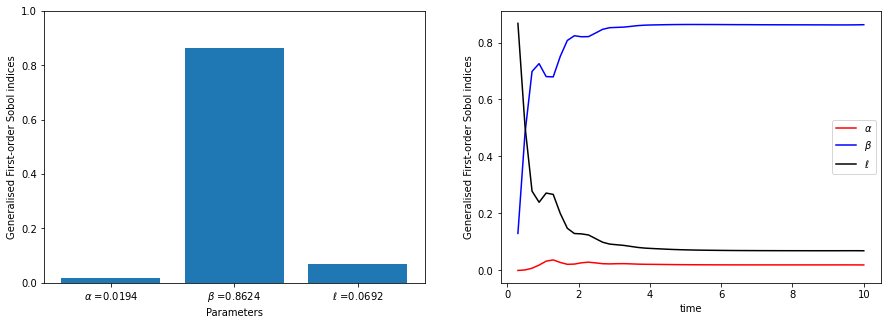

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

'Histogram of general total Sobol indices at t=T'
params = [r'$\alpha$ =' + str(np.around(G_U_evolution_PCE[0,-1], 4)), 
          r'$\beta$ =' +  str(np.around(G_U_evolution_PCE[1,-1], 4)), 
          r'$\ell$ =' +     str(np.around(G_U_evolution_PCE[2,-1], 4))]

ax[0].bar(params,G_U_evolution_PCE[:,-1])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Parameters')
ax[0].set_ylabel('Generalised First-order Sobol indices')

'Evolution of general total Sobol indices'
ax[1].plot(t_linspace,G_U_evolution_PCE[0,:], color = 'red',   label = r'$\alpha$')
ax[1].plot(t_linspace,G_U_evolution_PCE[1,:], color = 'blue',  label = r'$\beta$')
ax[1].plot(t_linspace,G_U_evolution_PCE[2,:], color = 'black', label = r'$\ell$')
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Generalised First-order Sobol indices')

# Total Order Indices

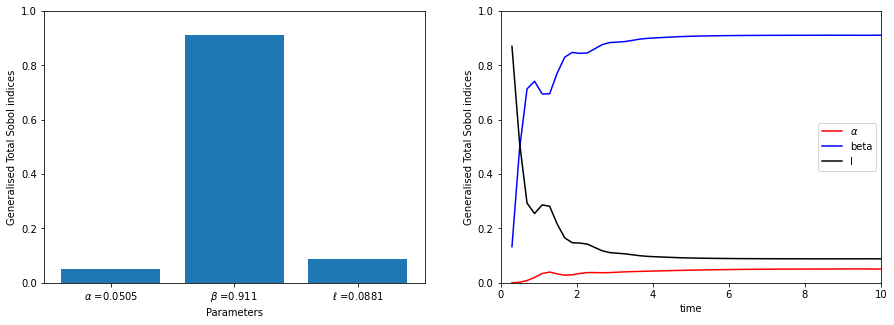

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

'Histogram of general total Sobol indices at t=T'
params = [r'$\alpha$ =' + str(np.around(G_total_U_evolution_PCE[0,-1], 4)), 
          r'$\beta$ =' +  str(np.around(G_total_U_evolution_PCE[1,-1], 4)), 
          r'$\ell$ =' +     str(np.around(G_total_U_evolution_PCE[2,-1], 4))]

ax[0].bar(params,G_total_U_evolution_PCE[:,-1])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Parameters')
ax[0].set_ylabel('Generalised Total Sobol indices')

'Evolution of general total Sobol indices'
ax[1].plot(t_linspace,G_total_U_evolution_PCE[0,:], color = 'red',   label = r'$\alpha$')
ax[1].plot(t_linspace,G_total_U_evolution_PCE[1,:], color = 'blue',  label = 'beta')
ax[1].plot(t_linspace,G_total_U_evolution_PCE[2,:], color = 'black', label = 'l')
plt.xlim(0, 10)
plt.ylim(0, 1)
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Generalised Total Sobol indices')
plt.show()

# Generalised Sobol Indices with KLE Surrogate

In [16]:
number_of_quadrature_points = 50 # numpy package has been tested upto degree 100

quad_points, quad_weights = GaussLegendreQuadrature(0, 10, number_of_quadrature_points)

# convert quad_weights vector to diagonal matrix
quad_weights = np.diag(quad_weights)

# find square root of weights
sqrt_quad_weights = np.sqrt(quad_weights)

In [17]:
n = 10_000 # number of 'instances'/'realisations'

t = quad_points # row vector
T = np.tile(t, (n, 1)) # repeat row 't' along axis 0

SampleSpace = mech_oscillator_samples(n) # generate samples

Y = mech_oscillator(SampleSpace, T) # compute output (displacement) [n, N_quad]

Y_mean = np.mean(Y, axis=0) # compute mean for each t_i
Y_std = np.std(Y, axis=0) # compute std for each t_i

# center the process
Y_c = Y-Y_mean

# Karhunen Loeve Expansion

Variance quantified by 10 terms = 0.9999957169060133


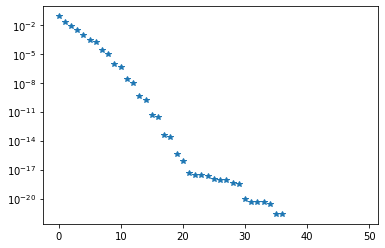

In [18]:
# Covariance matrix
# size: [N_quad, N_quad]
# unbiased estimator: 1/(n-1)
K = (1/(n-1))*np.dot(Y_c.T,Y_c)

# Pre and post multiply covariance matrix with
# square root of quadrature weights
K_new = sqrt_quad_weights @ K @ sqrt_quad_weights

# Eigenvalue Decomposition
eig_values, eig_vectors = np.linalg.eig(K_new)

# Compute true eigenvectors
weighted_eig_vectors = np.linalg.inv(sqrt_quad_weights) @ eig_vectors

# Discard imaginary part, as eigenvalues are real
eig_values = np.real(eig_values)

# Sort eigenvalues in descending order
# reverse sign -> sort in ascending -> reverse sign again
eig_values = -np.sort(-eig_values)

# truncation of KL expansion
n_kl = 10

# variance quantified by a given truncation level: n_kl
r_kl = np.sum(eig_values[:n_kl])/np.sum(eig_values)

print("Variance quantified by", n_kl, "terms =", r_kl)

# plot of eigenvalues
plt.semilogy(eig_values, '*')
plt.show()

In [19]:
# truncate eigenvector space
trunc_eig_vectors = weighted_eig_vectors[:,:n_kl] 

# project f_c (bzw. Y_c) on eigenvectors
# resulting matrix has size [N x n_kl]
# N evaluations for each of the n_kl vectors
Y_i =  Y_c @ quad_weights @ trunc_eig_vectors

In [25]:
class KLE_PCE_surrogate(PCE.PCE_surrogate):
    
    # Inherit from class PCE_surrogate from PolynomialChaosExpansion module
    
    '''
    Inputs:
    
        SampleSpace : Samples of random variables [N, N_p]
        
        n_kl : truncation level of KL-expansion
        
        n : total polynomial order
        
        func_vals : evaluated values of eigen_modes 
                    using which surrogate must be constructed [N x n_kl]
        
        eig_values : eigenvalues of the covariance operator
        
    
    Outputs:
    
        Generalised Sobol indices : [N_p, 1]
                                    history-aware index @ t = T of all random variables
    
    '''
    
    
    def __init__(self, SampleSpace, func_evals, total_polynomial_order, n_kl, eig_values, polynomial_classes_of_random_variables,  isoprob_transform):
        
        self.X = SampleSpace
        self.func_evals = func_evals
        self.eig_values = eig_values
        self.n_kl = n_kl
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables
        self.N_p = len(self.pcrv)
        self.isoprob_transform = isoprob_transform

        # set classes of random variables
        for i in range(self.N_p):
            
            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre
        
        #total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))
        
        # compute all permutations of monomials which have total degree <= n
        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)

    
    def generalised_Sobol(self, PCE_error):

        # coefficient pickers for first and total order index 
        first_order_picker, total_order_picker = self.coefficient_pickers()

        # store coefficients of polynomial surrogates for all eigenmodes
        # each column contains polynomial coefficients corresponding to each eigenmode
        # size = [number_of_PCE_terms, number of eigenmodes]
        store_beta = np.zeros((self.number_of_PCE_terms, self.n_kl))

        # store error for each mode
        self.store_PCE_error = np.zeros(self.n_kl)

        # compute coefficients of polynomial surrogates (beta) vector for each eigenmode (f_i)
        # f_i (bzw. Y_i) = projection of f (bzw. Y) on eig_vector_i
        for i in range(self.n_kl):

            store_beta[:,i] = self.find_coefficients(self.X, self.func_evals[:,i])

            if PCE_error:

                # error_estimate
                self.store_PCE_error[i] = self.LeaveOneOut(self.X, self.func_evals[:,i])
        
        # sum of squares of coefficients of eigenmodes for a given random varible
        # size [N_p, 1]
        G_first_numerator = np.sum(first_order_picker @ (store_beta**2), axis = 1)
        G_total_numerator = np.sum(total_order_picker @ (store_beta**2), axis = 1)

        # sum of eigenvalues for total variance
        # size [N_p, 1]
        G_denominator = np.sum(self.eig_values[:self.n_kl])

        # first order generalised Sobol index
        # size [N_p, 1]
        self.G_first = G_first_numerator/G_denominator

        # total generalised Sobol index
        # size [N_p, 1]
        self.G_tot = G_total_numerator/G_denominator
        
        'Plots'
        fig, ax = plt.subplots(1, 2, figsize=(15,5))

        'Histogram of general total Sobol indices at t=T'
        params = ['alpha=' + str(np.around(self.G_tot[0], 4)), 
                  'beta='  + str(np.around(self.G_tot[1], 4)), 
                   'l='    + str(np.around(self.G_tot[2], 4))]

        ax[0].bar(params, self.G_tot)
        ax[0].set_xlabel('Parameters')
        ax[0].set_ylabel('Total General Sobol indices')

        'Histogram of first order general Sobol indices at t=T'
        params = ['alpha=' + str(np.around(self.G_first[0], 4)), 
                  'beta='  + str(np.around(self.G_first[1], 4)), 
                   'l='    + str(np.around(self.G_first[2], 4))]

        ax[1].bar(params, self.G_tot)
        ax[1].set_xlabel('Parameters')
        ax[1].set_ylabel('First order General Sobol indices')

        plt.show()

        return self.G_first, self.G_tot

# Compute Generalised Sobol Indices

/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
/home/i1000609/.local/lib/python3.6/site-packages/ipykernel_launcher.py:77: ComplexWarning: Casting complex values to real discards the imaginary part


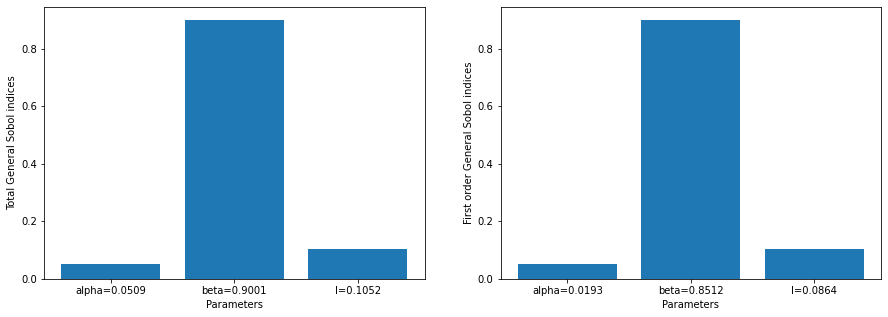

In [26]:
total_polynomial_degree = 10
polynomial_classes_of_random_variables = ['Legendre', 'Legendre', 'Legendre']

KLE_modes_PCE = KLE_PCE_surrogate(  SampleSpace, Y_i, total_polynomial_degree, n_kl, eig_values, 
                                    polynomial_classes_of_random_variables, 
                                    mech_oscillator_isoprob_transform)

G_first_KLE, G_tot_KLE = KLE_modes_PCE.generalised_Sobol(PCE_error=True)

# Compare Evolutions of MC and PCE

Text(0, 0.5, 'First-order Sobol indices')

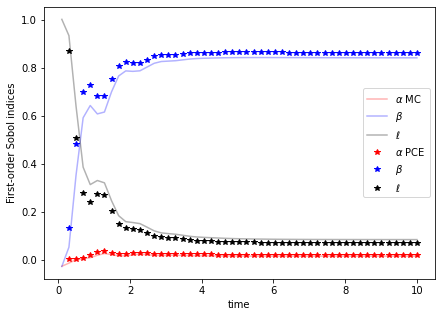

In [27]:
fig, ax = plt.subplots(1, 1,figsize=(7,5))

ax.plot(t_linspace, G_U_evolution_MC[0,:], '-', alpha = 0.3, color = 'red',   label = r'$\alpha$ MC')
ax.plot(t_linspace, G_U_evolution_MC[1,:], '-', alpha = 0.3, color = 'blue',  label = r'$\beta$')
ax.plot(t_linspace, G_U_evolution_MC[2,:], '-', alpha = 0.3, color = 'black', label = r'$\ell$')

ax.plot(t_linspace, G_U_evolution_PCE[0,:], '*', color = 'red',   label = r'$\alpha$ PCE')
ax.plot(t_linspace, G_U_evolution_PCE[1,:], '*', color = 'blue',  label = r'$\beta$')
ax.plot(t_linspace, G_U_evolution_PCE[2,:], '*', color = 'black', label = r'$\ell$')

ax.legend()
ax.set_xlabel('time')
ax.set_ylabel('First-order Sobol indices')

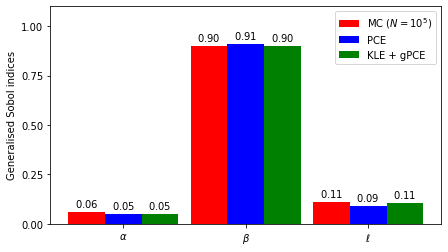

In [62]:
fig, ax = plt.subplots(figsize=(7,4))

params = [  r'$\alpha$', 
            r'$\beta$',
            r'$\ell$']

x = np.arange(3)
width = 0.3

rect1 = ax.bar(x - width,   G_total_U_evolution_MC[:,-1],   width, color = 'red',   label = r'MC ($N=10^5$)') 
rect2 = ax.bar(x ,          G_total_U_evolution_PCE[:,-1],  width, color = 'blue',  label = 'PCE')            
rect3 = ax.bar(x + width,   G_tot_KLE,                      width, color = 'green', label = 'KLE + gPCE') 

'Annotate each bar'
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()

        if height <= 1e-8:
            height = 0

        ax.annotate(r'${:.2f}$'.format(height),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)

ax.set_xticks(x)
ax.set_xticklabels(params)
ax.set_ylabel('Generalised Sobol indices')
ax.set_ylim(0,1.1)
ax.set_yticks(np.linspace(0,1.0,5))
ax.legend()